Calculate Kuiper metric for a given cadence for each point of the sky.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS
from datetime import datetime
from rubin_sim.maf.plots.spatialPlotters import HealpixSkyMap

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)

outDir = datetime.today().strftime('%d_%m_%Y_')+'varTypesPeriods'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [3]:
# Same for rolling cadence
rollDbFile = '/home/alex/rubin_sim_data/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [4]:
# Set range of periods for which we're gonna build the maps
start=0.1
numPoints=500
totalObsLength=365*7

periods=np.round(np.concatenate([np.geomspace(start,totalObsLength,numPoints),
                                 np.array([0.5,1,1.5,2,7,30,31,30*6])]),4)
periods=np.unique(periods)
periods=np.sort(periods)

In [5]:
numPoints=len(periods)

In [6]:
bundleList=[]
bundleListRoll=[]
summary_metrics = [maf.MedianMetric()]
sql = ''
nside=2**5 # for HealpixSlicer
slicer = maf.HealpixSlicer(nside=nside)
for p in periods:
    metric = KuiperVS(period=p)
    
    bundleList.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_metrics, 
                                       runName='KuiperMedian_'+str(p)))
    bundleListRoll.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_metrics, 
                                           runName='RollKuiperMedian_'+str(p)))

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [7]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['fiveSigmaDepth', 'rotSkyPos', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec'].
Found 2086980 visits
Running:  ['KuiperMedian_0_1_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1021_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1042_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1063_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1085_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1107_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_113_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1153_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1177_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1201_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'KuiperMedian_0_1226_KuiperVS_o

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
bdRoll = maf.metricBundles.makeBundlesDictFromList(bundleListRoll)
bgRoll = maf.metricBundles.MetricBundleGroup(bdRoll, rollDb, outDir=outDir, resultsDb=resultsDbRoll)
bgRoll.runAll()

Querying database observations with no constraint for columns ['fiveSigmaDepth', 'rotSkyPos', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec'].
Found 2088105 visits
Running:  ['RollKuiperMedian_0_1_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1021_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1042_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1063_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1085_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1107_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_113_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1153_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1177_KuiperVS_observationStartMJD_filter_fiveSigmaDepth_HEAL', 'RollKuiperMedian_0_1201_KuiperVS_observationStartMJD_filter_fiveSigmaDept

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [29]:
def getMedianMap(bList, minPeriod, maxPeriod):
    bList=[p for p in bList if ((float(p.runName.split('_')[1])>=minPeriod) & (float(p.runName.split('_')[1])<maxPeriod))]
    data=[np.where(p.metricValues.mask,0,p.metricValues.data) for p in bList]
    medMap = np.array([sum(i) for i in zip(*data)])/len(data)
    return medMap

In [88]:
medianMaps={}
medianMapsRoll={}
diffMaps={}

In [96]:
periodRanges=[0.1,1,2,5,10,100,300,400,1000,totalObsLength]
for i,p in enumerate(periodRanges[:-1]):
    medianMaps[p]=np.ma.masked_array(getMedianMap(bundleList,p,periodRanges[i+1]), 
                                     mask=np.where(getMedianMap(bundleList,p,periodRanges[i+1])==0,True,False))
    medianMapsRoll[p]=np.ma.masked_array(getMedianMap(bundleListRoll,p,periodRanges[i+1]), 
                          mask=np.where(getMedianMap(bundleListRoll,p,periodRanges[i+1])==0,True,False))
    diffMaps[p]=medianMaps[p]-medianMapsRoll[p]

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


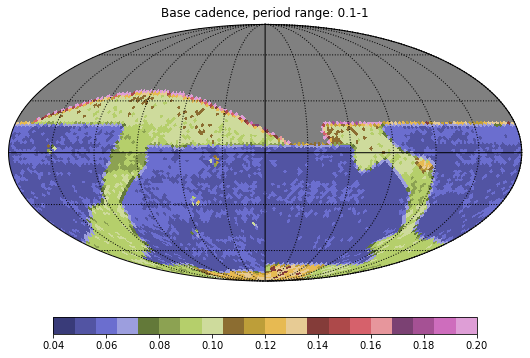

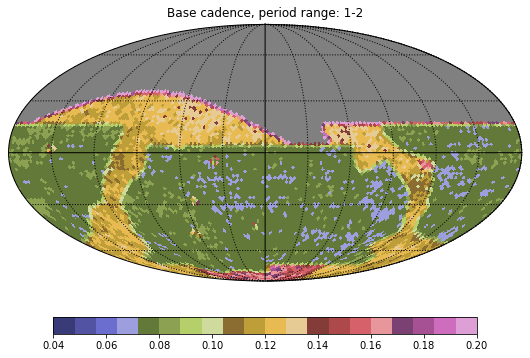

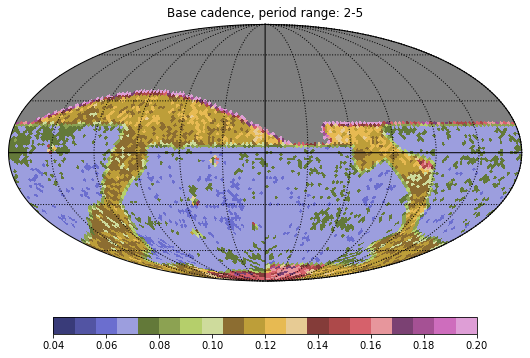

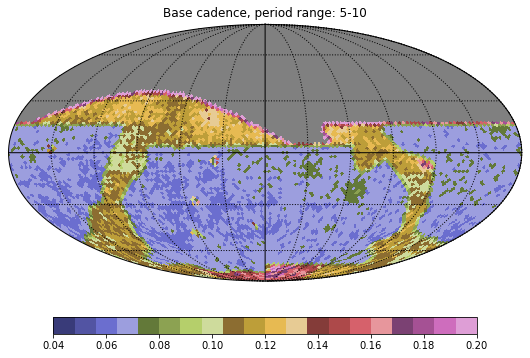

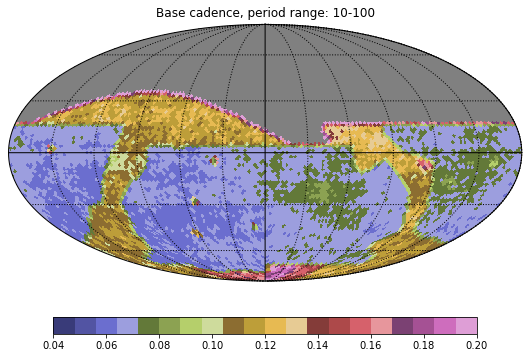

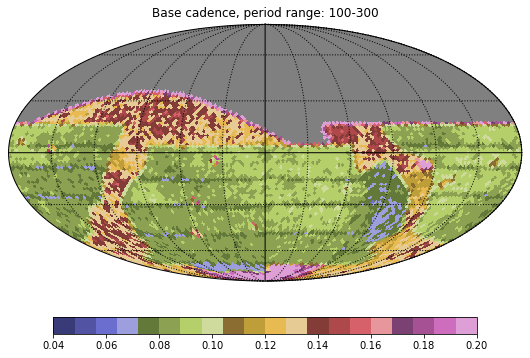

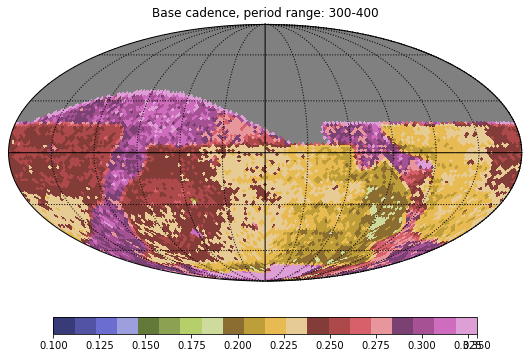

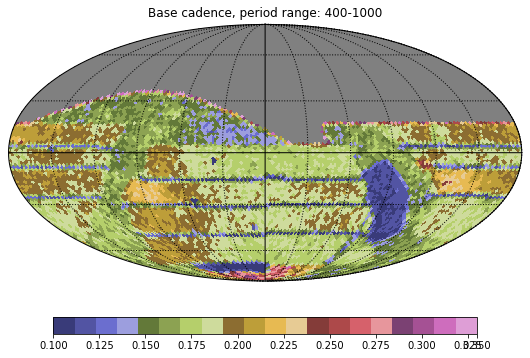

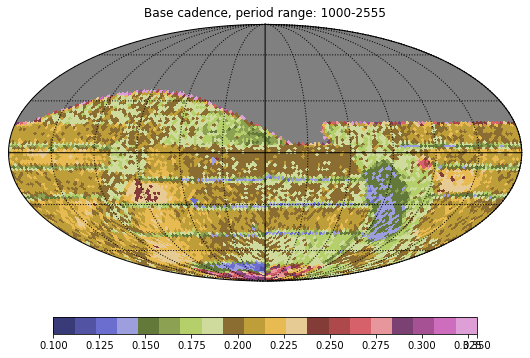

In [106]:
hpix=HealpixSkyMap()
userPlotDict={"colorMin": 0.04,"colorMax": 0.2,"cmap": plt.get_cmap("tab20b"),"figsize": (8, 5)}
for i,(key, val) in enumerate(medianMaps.items()):
    userPlotDict['title']='Base cadence, period range: '+str(key)+'-'+str(periodRanges[i+1])
    if key>=300:
        userPlotDict['colorMin']=0.1
        userPlotDict['colorMax']=0.33
    hpix.__call__(val, slicer, userPlotDict)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


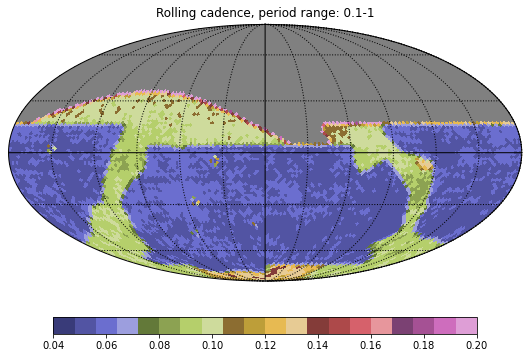

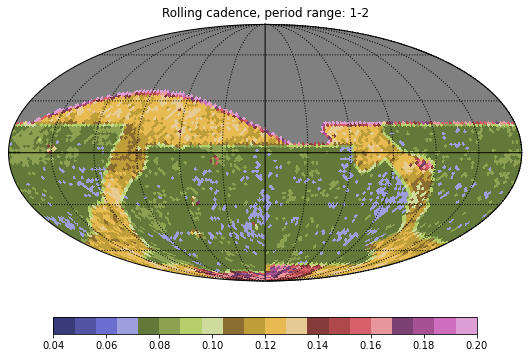

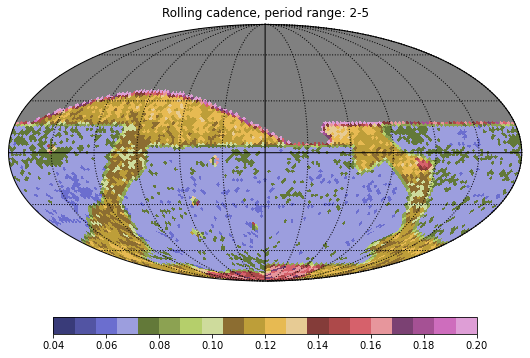

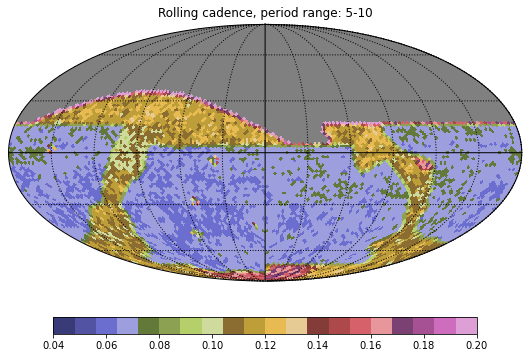

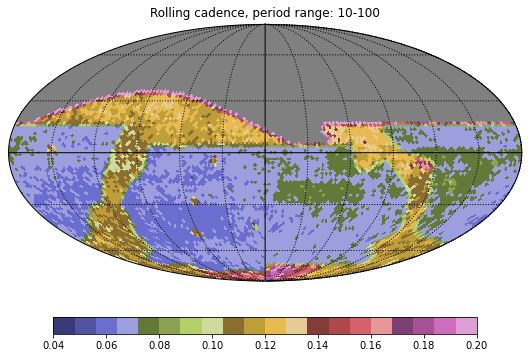

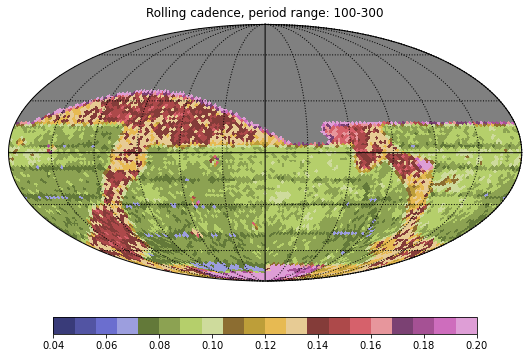

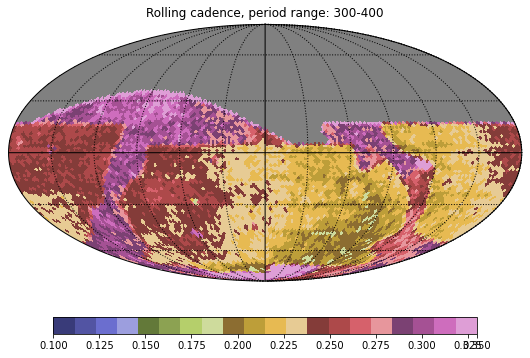

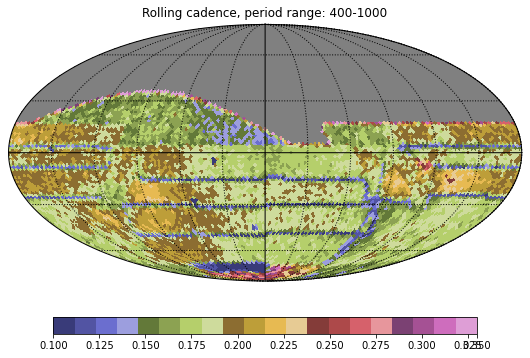

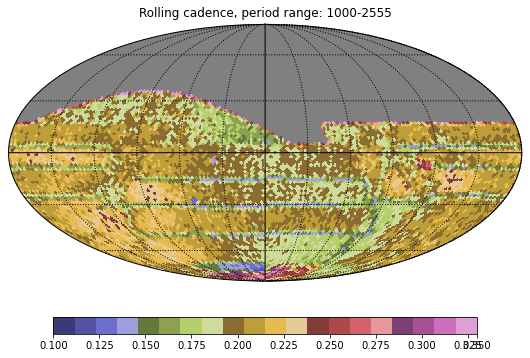

In [105]:
hpix=HealpixSkyMap()
userPlotDict={"colorMin": 0.04,"colorMax": 0.2,"cmap": plt.get_cmap("tab20b"),"figsize": (8, 5)}
for i,(key, val) in enumerate(medianMapsRoll.items()):
    userPlotDict['title']='Rolling cadence, period range: '+str(key)+'-'+str(periodRanges[i+1])
    if key>=300:
        userPlotDict['colorMin']=0.1
        userPlotDict['colorMax']=0.33
    hpix.__call__(val, slicer, userPlotDict)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


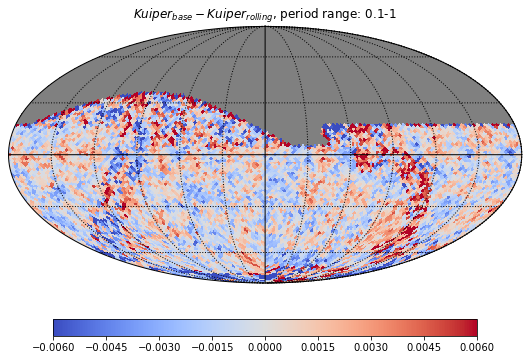

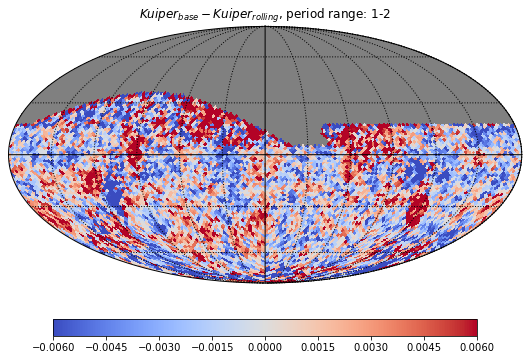

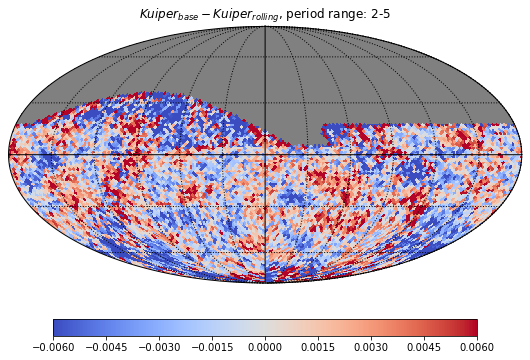

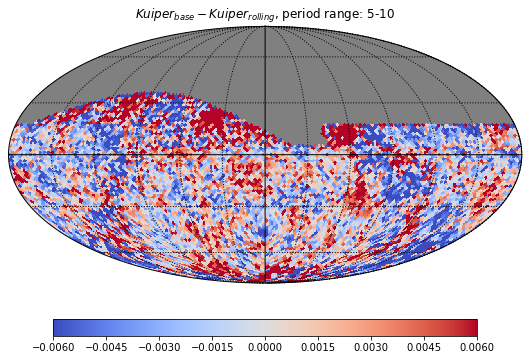

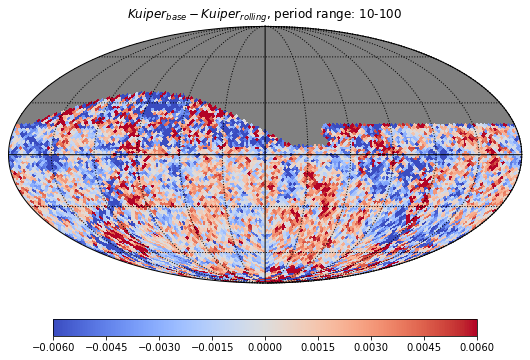

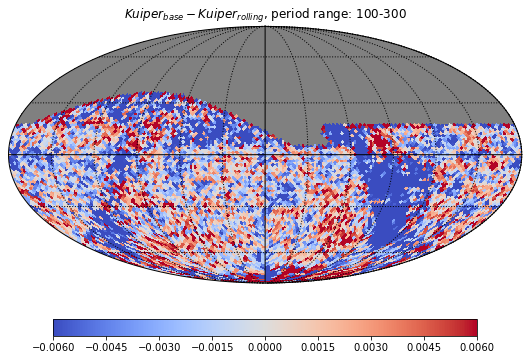

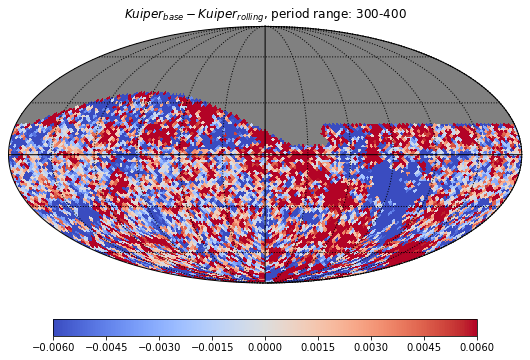

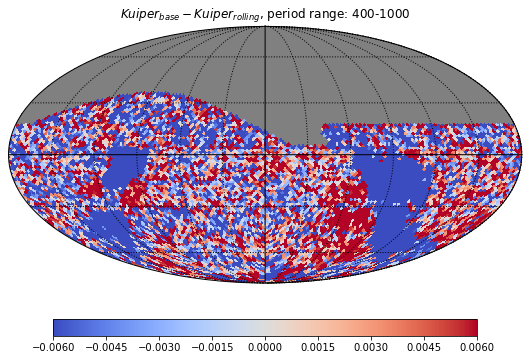

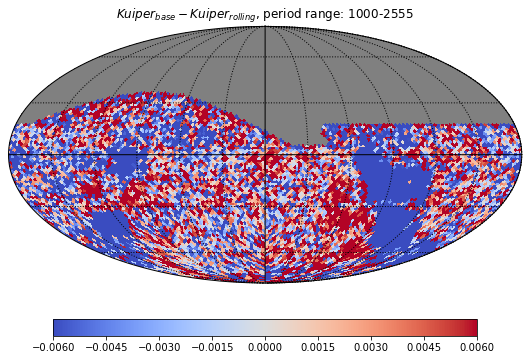

In [99]:
hpix=HealpixSkyMap()
userPlotDict={"colorMin": -0.006,"colorMax": 0.006,"cmap": plt.get_cmap("coolwarm"),"figsize": (8, 5)}
for i,(key, val) in enumerate(diffMaps.items()):
    userPlotDict['title']='$Kuiper_{base}-Kuiper_{rolling}$, period range: '+str(key)+'-'+str(periodRanges[i+1])
    hpix.__call__(val, slicer, userPlotDict)